# Mask R-CNN - Inspect Ballon Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import os
import sys
import random
import math
import re
import time
import numpy as np

%tensorflow_version 1.x
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

# Root directory of the project
gdrive_path = '/content/gdrive/My Drive/Colab Notebooks/'
ROOT_DIR = os.path.abspath(gdrive_path +"Project_Nuggi")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.gogi import gogi

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs/gogi_single/")

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
BALLON_WEIGHTS_PATH = "/path/to/mask_rcnn_balloon.h5"  # TODO: update this path

TensorFlow 1.x selected.


Using TensorFlow backend.


## Configurations

In [ ]:
# Override the training configurations with a few
# changes for inferencing.

config = gogi.BalloonConfig()

class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook Preferences

In [ ]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

## Load Model

In [ ]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [ ]:
# Set path to balloon weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
# weights_path = "/path/to/mask_rcnn_balloon.h5"

# Or, load the last model you trained
# weights_path = model.find_last()
weights_path = MODEL_DIR + 'mask_rcnn_gogi_0030.h5'

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /content/gdrive/My Drive/Colab Notebooks/Project_Nuggi/logs/gogi_single/mask_rcnn_gogi_0030.h5


#  Image Path & Load Images to Crop and Save

In [ ]:
IMAGE_DIR = os.path.join(ROOT_DIR, "samples/gogi/datasets/multiple_gogi/test/" ) # datasets/cooked/ or multiple_gogi/cooked or multiple_gogi/test
files = os.listdir(IMAGE_DIR) # filter image file
images = list()


#       이미 존재하는 데이터셋은 crop하지 않는다.     #
EXIST_DIR = os.path.join(gdrive_path, "Project_GogiMaster/datasets/test/" ) # datasets/test or cooked or uncooked
exist_files = os.listdir(EXIST_DIR)

for exist_file in exist_files:
  
  exist_file_name = '_'.join(exist_file.split('_')[1:])
  # print(exist_file_name)
  # breakpoint

  try:
    files.remove(exist_file_name)
    
  except Exception as e:
    pass
    # print(e)
# breakpoint


#           이미지 데이터만 추출          #
for i, value in enumerate(files):

  try:
    if value.split('.')[1] in ['jpg', 'png']:
      images.append(value)
  
  except:
    continue

# print(images.remove(exist_files))
# print(exist_files)
print(len(images), 'images')

1 images


# Get Mask and Crop in Rectangle shape

Processing 1 images
image                    shape: (4032, 2268, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 4032.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
(1355, 1228) float32


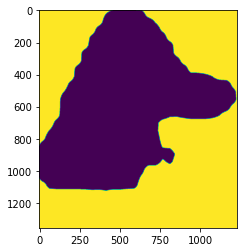

0 63 1355 1228


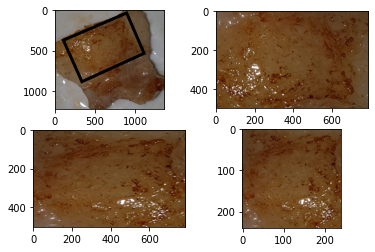

/content/gdrive/My Drive/Colab Notebooks/Project_GogiMaster/datasets/test/500_test.jpg saved


In [ ]:
from extractRect import findRotMaxRect

def apply_mask(image, mask, color=(0, 0, 0), alpha=1.):
    """Apply the given mask to the image.
    """
    
    for c in range(3):
        # Background Masking
        color = 1, 1, 1
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
        
        # Gogi Masking
        color = 0, 0, 0
        image[:, :, c] = np.where(mask == 0,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image


for image_name in images:

  # image_name = 'a11221510.jpg'

  image = cv2.imread(IMAGE_DIR + image_name, cv2.IMREAD_COLOR)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  # print(image)
  # plt.imshow(image)
  # plt.show()

  results = model.detect([image], verbose=1)
  # breakpoint

  r = results[0]
  # print(r)
  # breakpoint

  for i, point in enumerate(r['rois']):

    # if i != 1:
    #   continue
    # print(point)
    y1, x1, y2, x2 = point

    roi_image = image.copy()
    # roi_image_a = roi_image[::-1].T

    # color = colors[0]
    # color = 1., 1. ,1.

    mask = r['masks'][:, :, i]
    # print(masked_image.shape)
    # print(mask.shape)
    masked_image = apply_mask(roi_image.astype(np.uint32), mask)
    # plt.imshow(masked_image[y1:y2, x1:x2].astype(np.float32))
    # plt.show()
    # print(masked_image.shape)
    # breakpoint
    
    a = cv2.cvtColor(masked_image[y1:y2, x1:x2].astype(np.float32), cv2.COLOR_BGR2GRAY)[::-1].T
    b = roi_image[y1:y2, x1:x2][::-1].T

    idx_in = np.where(a == 255)
    idx_out = np.where(a == 0)
    aa = np.ones_like(a)
    aa[idx_in] = 0

    # plt.subplot(121)
    print(aa.shape, aa.dtype)
    plt.imshow(aa)
    # plt.title('%s Score : %.5f' % (image_name, r['scores'][i]), fontsize=20, color='white')
    # plt.axis('off')
    
    # plt.subplot(122)
    # plt.imshow(b.T)
    plt.show()

    try:
      rect_coord_ori, angle, coord_out_rot = findRotMaxRect(aa, flag_opt=True, nbre_angle=4,
                                                                flag_parallel=False,
                                                                flag_out='rotation',
                                                                flag_enlarge_img=False,
                                                                limit_image_size=100)
      
    except Exception as e:
      print(e)
      continue

    fig = plt.figure()
    ax = fig.add_subplot(221, aspect='equal')
    
    # 점 이동 확인
    # rect_coord = np.array(rect_coord_ori).astype(np.uint32)
    # print(rect_coord[0])
    # cv2.circle(b.T, tuple(rect_coord[0]), 1000, (255,0,0),-1)
    # cv2.circle(b.T, tuple(rect_coord[1]), 10, (0,255,0),-1)
    # cv2.circle(b.T, tuple(rect_coord[2]), 10, (0,0,255),-1)
    # plt.imshow(b.T)
    # plt.show()
    ax.imshow(b.T)

    # ax.imshow(b.T, origin='lower', interpolation='nearest')
    patch = patches.Polygon(rect_coord_ori, edgecolor='black', facecolor='None', linewidth=3)
    ax.add_patch(patch)

    # rect_coord_ori : 좌상, 우상, 우하, 좌하
    pts = np.array(rect_coord_ori)
    sm = pts.sum(axis=1)                 # 4쌍의 좌표 각각 x+y 계산
    diff = np.diff(pts, axis=1)       # 4쌍의 좌표 각각 x-y 계산  

      
    # for i in range(len(diff)):
    #   for j in range(i + 1, len(diff)):
    #     print(diff[i], diff[j])
    #     if int(diff[i]) == int(diff[j]):
    #       diff[j] += 0.01
    #       print(diff)
    # breakpoint
      #  diff[np.argmin(diff)]  += 0.01
      #  diff[np.argmax(diff)]  += 0.01   

    # print(pts)
    # print(sm)

    topLeft = pts[np.argmin(sm)]         # x+y가 가장 작은 값이 좌상단 좌표
    bottomRight = pts[np.argmax(sm)]     # x+y가 가장 큰 값이 좌상단 좌표
    # diff index에서 topLeft, bottomRight 인덱스는 제거해준다.
    diff[np.argmin(sm)] = 0
    diff[np.argmax(sm)] = 0
    # print(diff) 

    topRight = pts[np.argmin(diff)]     # x-y가 가장 작은 것이 우상단 좌표
    bottomLeft = pts[np.argmax(diff)]   # x-y가 가장 큰 값이 좌하단 좌표
    # print(np.argmin(sm), np.argmax(sm), np.argmin(diff), np.argmax(diff))


    # rect_coord_reorder : 좌상, 우상, 우하, 좌하
    pts1 = np.float32([topLeft, topRight, bottomRight , bottomLeft])
    # print(pts1)
    # breakpoint

    width = abs(topLeft[0] - topRight[0])
    height = abs(topRight[1] - bottomRight[1])
    # pts1 = np.float32(rect_coord_ori)
    pts2 = np.float32([[0, height], [width, height], [width, 0], [0, 0]])
    # print(pts2)
    # breakpoint

    M = cv2.getPerspectiveTransform(pts1, pts2)
    dst = cv2.warpPerspective(b.T, M, (int(width), int(height)))
    ax = plt.subplot(222)
    ax.imshow(dst)

    #         고기 이상치 제외        #
    error_prob = 0
    for i in range(2, len(dst)):
      if sum(dst[i - 1] == dst[i])[0] == len(dst[i]):
        error_prob = 1
    
    if error_prob == 1:
      plt.close()
      continue

    #      세로가 가로보다 길면, 90 도 회전       #
    if dst.shape[0] < dst.shape[1]:
      ax = plt.subplot(223)
      # dst_enlarge = cv2.resize(dst, (300, 150))
      # ax.imshow(dst_enlarge)
      pts1 = np.float32([[0, height], [width, height], [width, 0], [0, 0]])
      pts2 = np.float32([[width, height], [width, 0], [0, 0], [0, height]])
      M = cv2.getPerspectiveTransform(pts1, pts2)
      dst = cv2.warpPerspective(dst, M, (int(width) , int(height)))
      # matrix = cv2.getRotationMatrix2D((dst.shape[0]/2, dst.shape[1]/2), 90, 1.)
      # dst = cv2.warpAffine(dst, matrix, (dst.shape[0], dst.shape[1]))
      ax.imshow(dst)

    #       IMAGE DATA RESIZE     #
    dst = cv2.resize(dst, (250, 250))[10:, :-10]
    ax = plt.subplot(224)
    ax.imshow(dst)
    plt.show()
    # plt.close()
    # breakpoint

    #     save path    #
    if 'uncooked' in IMAGE_DIR:
      save_path = gdrive_path +"Project_GogiMaster/datasets/uncooked/"
    elif 'test' in IMAGE_DIR:
      save_path = gdrive_path +"Project_GogiMaster/datasets/test/"
    else:
      save_path = gdrive_path +"Project_GogiMaster/datasets/cooked/"    

    print(save_path + '%s_' % i + image_name, 'saved')

    # cv2.imwrite(save_path + '%s_' % i + image_name, dst)
    # breakpoint


    # load_image = cv2.imread(save_path + image_name)
    # plt.imshow(load_image)
    # plt.show()

    # print(masked_image[y1:y2, x1:x2].shape)
    # print(load_image.shape)
    # breakpoint()



# Feed Images, Crop and Save



In [ ]:
def apply_mask(image, mask, color, alpha=1.):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 0,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image


for image_name in images:

  image = cv2.imread(IMAGE_DIR + image_name, cv2.IMREAD_COLOR)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  # plt.imshow(image)
  # plt.show()
  # break
  results = model.detect([image], verbose=1)
  r = results[0]

  for i, point in enumerate(r['rois']):

    # print(point)
    y1, x1, y2, x2 = point

    masked_image = image.astype(np.uint32).copy()
    # color = colors[0]
    color = 1., 1. ,1.

    mask = r['masks'][:, :, i]
    # print(masked_image.shape)
    # print(mask.shape)
    masked_image = apply_mask(masked_image, mask, color)

    plt.imshow(masked_image[y1:y2, x1:x2])
    plt.title('%s Score : %.5f' % (image_name, r['scores'][i]), fontsize=20, color='white')
    plt.axis('off')
    plt.show()

    #     save path    #
    if 'uncooked' in IMAGE_DIR:
      save_path = gdrive_path +"Project_GogiMaster/datasets/uncooked/"
    else:
      save_path = gdrive_path +"Project_GogiMaster/datasets/cooked/"

    #       test path      on / off   #
    save_path = gdrive_path +"Project_GogiMaster/test/"


    print(save_path + '%s_' % i + image_name, 'saved')

    # cv2.imwrite(save_path + '%s_' % i + image_name, masked_image[y1:y2, x1:x2].astype(np.float32))


    # load_image = cv2.imread(save_path + image_name)
    # plt.imshow(load_image)
    # plt.show()

    # print(masked_image[y1:y2, x1:x2].shape)
    # print(load_image.shape)
    # breakpoint()



# Video Path & Load Video to Image

In [ ]:
VIDEO_DIR = os.path.join(ROOT_DIR, "samples/gogi/datasets/cooked/")
files = os.listdir(VIDEO_DIR)
videos = list()

for i, value in enumerate(files):

  # print(value.split('.')[1])

  if value.split('.')[1] in ['mkv', 'mp4']:
    videos.append(value)

print(videos)

for video in videos:
  
  cap = cv2.VideoCapture(VIDEO_DIR + video)

  total_frame = cap.get(cv2.CAP_PROP_FRAME_COUNT)
  cap_term = 5 # frames

  while(cap.isOpened()):
    
    ret, frame = cap.read()

    current_frame = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
    # print(current_frame / cap_term)
    if current_frame % cap_term == 0:
      # print(current_frame)
      frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      plt.imshow(frame)
      # plt.show()
      image_name = video.split('.')[0] + '_%s.jpg' % current_frame
      plt.savefig(VIDEO_DIR + image_name)
      print(image_name, 'saved')

    if current_frame == total_frame:
      break

  cap.release()


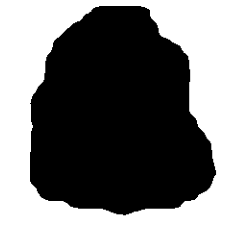

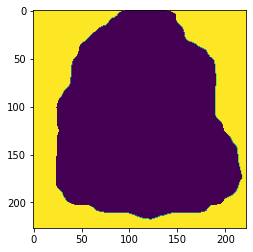

error: ignored

In [ ]:
cropped_image = masked_image[y1:y2, x1:x2]
plt.imshow(cropped_image)
plt.axis('off')
plt.show()
# print(cropped_image.shape)
gray_img = cv2.cvtColor(cropped_image.astype(np.float32), cv2.COLOR_RGB2GRAY)
plt.imshow(gray_img)
plt.show()

contour_img, contours = cv2.findContours(gray_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
plt.imshow(contour_img)


## Run Detection

In [ ]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# Load validation dataset


In [ ]:
BALLOON_DIR = os.path.join(ROOT_DIR, "samples/gogi/datasets/multiple_gogi")

dataset = gogi.BalloonDataset()
dataset.load_balloon(BALLOON_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 3
Classes: ['BG', 'gogi']


Processing 1 images
image                    shape: (909, 1200, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1200.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


NameError: ignored

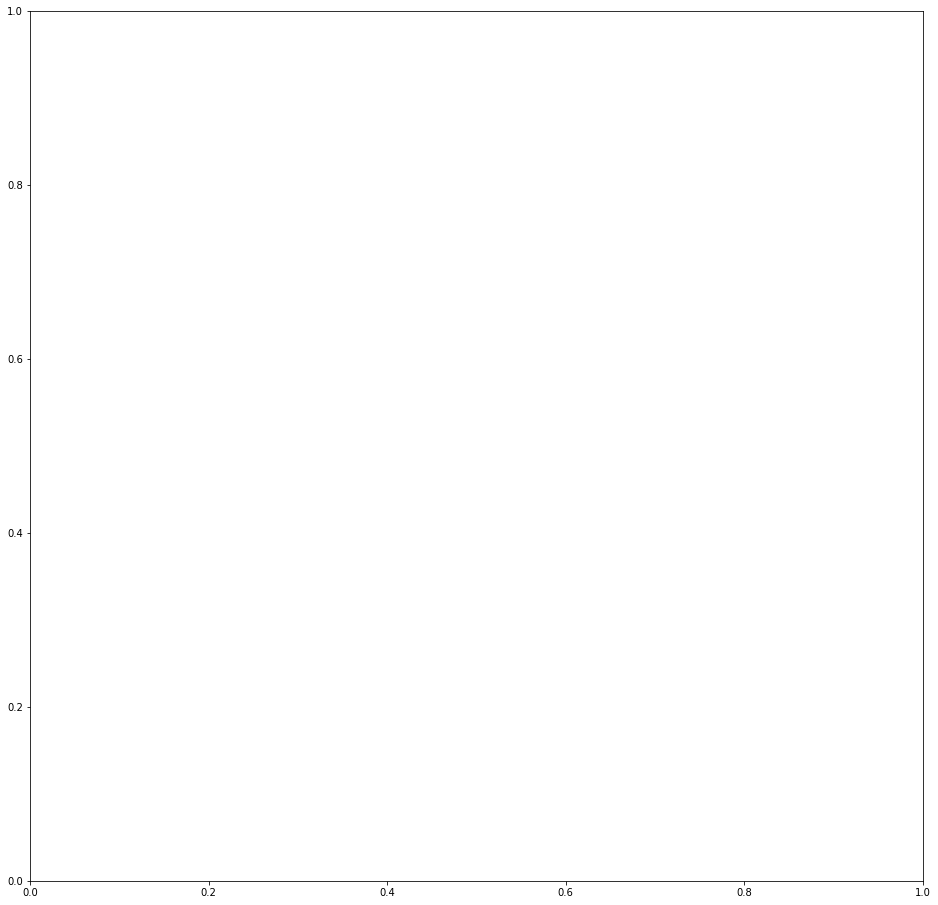

In [ ]:


image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize_result = visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)